In [1]:
import os
import rioxarray
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio as rio
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from rasterstats import zonal_stats
from shapely.geometry import Polygon


In [2]:


base_dir = Path(os.getenv("BASE_DIR"))
#fubu_fp = base_dir.joinpath("outputs/NetCDF/nsidc_0051_sic_nasateam_1979-2018_north_smoothed_fubu_dates.nc")

#ds = xr.load_dataset(fubu_fp)

In [5]:
base_dir.parent

PosixPath('/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators')

In [6]:
in_dir = base_dir.joinpath("nsidc_0051/raw/daily")

In [15]:
np.all(["v1.1" in str(fp) for fp in list(in_dir.glob("*.bin"))])


True

In [32]:
base_dir.joinpath("nsidc_0051/raw/daily/nt_19781026_n07_v1.1_n.bin").exists()

True

In [30]:
list(base_dir.joinpath("nsidc_0051/raw/daily").glob("*"))

[PosixPath('/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/nsidc_0051/raw/daily/nt_19781026_n07_v1.1_n.bin'),
 PosixPath('/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/nsidc_0051/raw/daily/nt_19781026_n07_v1.1_n.bin.xml'),
 PosixPath('/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/nsidc_0051/raw/daily/nt_19781028_n07_v1.1_n.bin'),
 PosixPath('/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/nsidc_0051/raw/daily/nt_19781028_n07_v1.1_n.bin.xml'),
 PosixPath('/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/nsidc_0051/raw/daily/nt_19781030_n07_v1.1_n.bin'),
 PosixPath('/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/nsidc_0051/raw/daily/nt_19781030_n07_v1.1_n.bin.xml'),
 PosixPath('/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/nsidc_0051/raw/daily/nt_19781101_n07_v1.1_n.bin'),
 PosixPath('/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/proj

In [20]:
!ls $BASE_DIR/nsidc_0051/raw/daily

nt_197811_n07_v1.1_n.bin      nt_199812_f13_v1.1_n.bin
nt_197811_n07_v1.1_n.bin.xml  nt_199812_f13_v1.1_n.bin.xml
nt_197812_n07_v1.1_n.bin      nt_199901_f13_v1.1_n.bin
nt_197812_n07_v1.1_n.bin.xml  nt_199901_f13_v1.1_n.bin.xml
nt_197901_n07_v1.1_n.bin      nt_199902_f13_v1.1_n.bin
nt_197901_n07_v1.1_n.bin.xml  nt_199902_f13_v1.1_n.bin.xml
nt_197902_n07_v1.1_n.bin      nt_199903_f13_v1.1_n.bin
nt_197902_n07_v1.1_n.bin.xml  nt_199903_f13_v1.1_n.bin.xml
nt_197903_n07_v1.1_n.bin      nt_199904_f13_v1.1_n.bin
nt_197903_n07_v1.1_n.bin.xml  nt_199904_f13_v1.1_n.bin.xml
nt_197904_n07_v1.1_n.bin      nt_199905_f13_v1.1_n.bin
nt_197904_n07_v1.1_n.bin.xml  nt_199905_f13_v1.1_n.bin.xml
nt_197905_n07_v1.1_n.bin      nt_199906_f13_v1.1_n.bin
nt_197905_n07_v1.1_n.bin.xml  nt_199906_f13_v1.1_n.bin.xml
nt_197906_n07_v1.1_n.bin      nt_199907_f13_v1.1_n.bin
nt_197906_n07_v1.1_n.bin.xml  nt_199907_f13_v1.1_n.bin.xml
nt_197907_n07_v1.1_n.bin      nt_199908_f13_v1.1_n.bin
nt_197907_n07_v1.1_n.bin.xml  nt_

In [7]:
# Here need to look into the issue of weird behavior in plots. 

# First, more mass of distribution of breakup end dates occurs earlier in year 
# than most breakup start dates. Look into this for the yellow sea. 
base_dir = Path(os.getenv("BASE_DIR"))
fubu_fp = base_dir.joinpath("outputs/NetCDF/nsidc_0051_sic_nasateam_1979-2018_north_smoothed_fubu_dates.nc")

ds = xr.load_dataset(fubu_fp)

In [14]:
# get MAISE polygons

def get_polygon(row):
    """Create shapely polygon object from row of 
    alternating lat/lon coords
    
    Row matches format of the MAISE polygons excel file: (MASIE_regions_polygon_vertices.xls)
    """
    df_di = {"lat": [], "lon": []}
    for idx, value in zip(row.index, row):
         
        if pd.isnull(value):
            df_di["lat"].append(df_di["lat"][0])
            df_di["lon"].append(df_di["lon"][0])
            break
        if "Lat" in idx:
            df_di["lat"].append(value)
        if "Lon" in idx:
            df_di["lon"].append(value)
            
    df = pd.DataFrame(df_di)
    
    return Polygon(list(zip(df.lon, df.lat)))


masie_fp = base_dir.joinpath("ancillary/MASIE_regions_polygon_vertices.xls")
df = pd.read_excel(masie_fp, skiprows=1)

polys = df[["Region Number Identifier", "Name"]].copy()
for index, row in df.iterrows(): 
    polys.loc[index, "geometry"] = get_polygon(row)

polys = gpd.GeoDataFrame(polys).set_crs(epsg=4326).to_crs(epsg=3411)

In [19]:
# compute stats for all variables

with rio.open(f"netcdf:{fubu_fp}:breakup_end") as src:
    affine = src.meta["transform"]

zs = {}
for variable in list(ds.variables)[:4]:
    zs[variable] = [
        zonal_stats(
            polys, 
            arr, 
            affine=affine,
            nodata=np.nan, 
            stats=["mean"],
        ) 
        for arr in ds[variable].values
    ]

In [90]:
xds = rioxarray.open_rasterio(fubu_fp).rio.write_crs("epsg:3411")

In [117]:
poly = polys[polys["Name"] == "Yellow Sea"]["geometry"]
clipped = xds.rio.clip(poly.values, poly.crs)

<ipython-input-118-96beb3f18f46>:1: RuntimeWarning: Mean of empty slice
  plt.hist(np.nanmean(clipped["breakup_start"].values, axis=(1,2)))


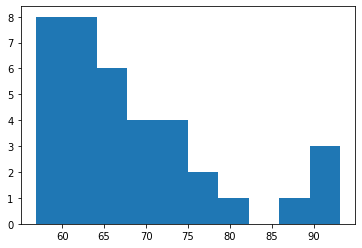

In [118]:
plt.hist(np.nanmean(clipped["breakup_start"].values, axis=(1,2)))
plt.show()

<ipython-input-119-8f017bce6ca5>:1: RuntimeWarning: Mean of empty slice
  plt.hist(np.nanmean(clipped["breakup_end"].values, axis=(1,2)))


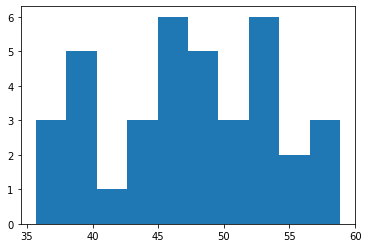

In [119]:
plt.hist(np.nanmean(clipped["breakup_end"].values, axis=(1,2)))
plt.show()

In [108]:
# clearly there is a problem. 
# Next thing to try is just testing whether breakup start dates happen 
# before breakup end dates by taking the difference

diffs = clipped["breakup_end"].values - clipped["breakup_start"].values

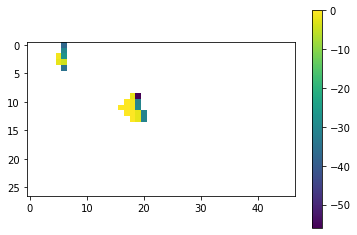

In [110]:
plt.imshow(diffs[4])
plt.colorbar()

In [127]:
print(clipped["breakup_start"].values[0][0][6])
print(clipped["breakup_end"].values[0][0][6])

92.0
52.0


In [115]:
# Try a different region to see if the same isssue exists
poly = polys[polys["Name"] == "Chukchi Sea"]["geometry"]
clipped = xds.rio.clip(poly.values, poly.crs)
diffs = clipped["breakup_end"].values - clipped["breakup_start"].values

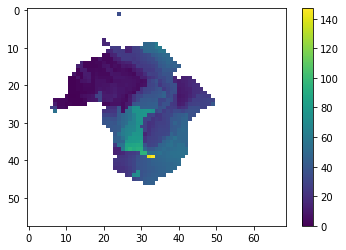

In [116]:
plt.imshow(diffs[0])
plt.colorbar()

<ipython-input-88-adb1cee2c6b9>:1: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(clipped["freezeup_start"].values, axis=0))


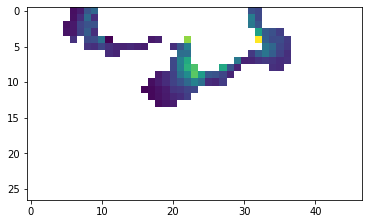

In [88]:
plt.imshow(np.nanmean(clipped["freezeup_start"].values, axis=0))

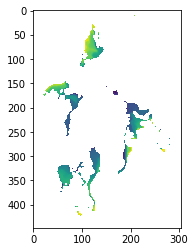

In [84]:
plt.imshow(xds["freezeup_start"].values[0])

In [23]:
!ls /home/UA/kmredilla/scratch/seaice_noaa_indicators/nsidc_sample_20181231.tif

/home/UA/kmredilla/scratch/seaice_noaa_indicators/nsidc_sample_20181231.tif


In [24]:
os.environ["BASE_DIR"] = "/workspace/Shared/Tech_Projects/SeaIce_NOAA_Indicators/project_data/nsidc_0051"
os.environ["SCRATCH_DIR"] = "/home/UA/kmredilla/scratch/seaice_noaa_indicators"

In [25]:
base_dir = os.getenv("BASE_DIR")
scratch_dir = os.getenv("SCRATCH_DIR")
fn = "nsidc_0051_sic_nasateam_1979-2018_north_smoothed_fubu_dates.nc"
# computed fubu dates fp
fp = os.path.join(base_dir, "outputs", "NetCDF", fn)
# sample fp for mask
samp_fp = os.path.join(scratch_dir, "nsidc_sample_20181231.tif")


In [12]:
# load fubu dates netCDF
with xr.open_dataset(fp) as ds:
    fubu_ds = ds.load().copy()

In [35]:
# set up meta data for saving GeoTIFFs
with rio.open(samp_fp) as src:
    samp_arr = src.read(1)
    meta = src.meta
meta.update(dtype='int32', compress='lzw', count=1)

In [36]:
fu_start = fubu_ds["freezeup_start"].values
valid = np.isnan(fu_start) == False
counts = np.sum(valid, axis=0)
counts[samp_arr == 254.] = -9999
plt_arr = np.ma.masked_where(samp_arr == 254., counts)

<ipython-input-38-4da87a830964>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_bad(color='black')


(-0.5, 303.5, 447.5, -0.5)

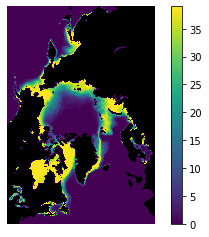

In [38]:
cmap = plt.cm.viridis
cmap.set_bad(color='black')
plt.imshow(plt_arr, interpolation='none', cmap=cmap)
plt.colorbar()
plt.axis('off')

In [ ]:
da_valid[da_sid == 254.] = -9999
da_plt = np.ma.masked_where(samp_arr == 254., da_valid)

In [ ]:

cmap = plt.cm.viridis
cmap.set_bad(color='black')
be_plt_fn = 'C:/Users/Keal/Desktop/IARC/Sea_Ice/figures/nan_fubu_counts_testing/n_valid_' + metric + '.png'
plt.imshow(da_plt, interpolation='none', cmap=cmap)
plt.title('Years where ' + metric.replace('_', ' ') + ' defined')
plt.colorbar()
plt.axis('off')
plt.savefig(be_plt_fn)
plt.close()

In [29]:
fubu_ds

<xarray.Dataset>
Dimensions:         (xc: 304, yc: 448, year: 39)
Coordinates:
  * xc              (xc) float64 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * yc              (yc) float64 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * year            (year) int64 1979 1980 1981 1982 ... 2014 2015 2016 2017
Data variables:
    freezeup_start  (year, yc, xc) float32 nan nan nan nan ... nan nan nan nan
    freezeup_end    (year, yc, xc) float32 nan nan nan nan ... nan nan nan nan
    breakup_start   (year, yc, xc) float32 nan nan nan nan ... nan nan nan nan
    breakup_end     (year, yc, xc) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    proj4string:       EPSG:3411
    proj_name:         NSIDC North Pole Stereographic
    affine_transform:  [25000.0, 0.0, -3850000.0, 0.0, -25000.0, 5850000.0, 0...

In [ ]:
for metric in ds:
    da = ds[metric].values
    m_da = np.isnan(da)
    m_da = m_da == False
    da_valid = np.sum(m_da, axis=0)
    da_valid[da_sid == 254.] = -9999
    da_plt = np.ma.masked_where(da_sid == 254., da_valid)
    cmap = plt.cm.viridis
    cmap.set_bad(color='black')
    be_plt_fn = 'C:/Users/Keal/Desktop/IARC/Sea_Ice/figures/nan_fubu_counts_testing/n_valid_' + metric + '.png'
    plt.imshow(da_plt, interpolation='none', cmap=cmap)
    plt.title('Years where ' + metric.replace('_', ' ') + ' defined')
    plt.colorbar()
    plt.axis('off')
    plt.savefig(be_plt_fn)
    plt.close()
    # save GeoTIFF
    tif_fn = 'C:/Users/Keal/Desktop/IARC/Sea_Ice/data/nan_fubu_counts_testing/n_valid_' + metric + '.tif'
    with rasterio.open(tif_fn, 'w', **meta) as out:
        out.write(da_plt, 1)